In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("features.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)


In [4]:
import joblib

clf = joblib.load("stability_model.pkl")
scaler = joblib.load("stability_scaler.pkl")


In [5]:
df["occupied_now"] = (df["g1_min"] < 300).astype(int)

In [6]:
def make_stability_labels(df, horizon_seconds=900):
    df = df.copy()
    df["ts"] = (df["timestamp"] - df["timestamp"].iloc[0]).dt.total_seconds()

    labels = []
    for i in range(len(df)):
        t_now = df.loc[i, "ts"]
        t_future = t_now + horizon_seconds

        mask = (df["ts"] > t_now) & (df["ts"] <= t_future)
        if mask.sum() == 0:
            labels.append(0)
            continue

        occ_now = df.loc[i, "occupied_now"]
        occ_future = df.loc[mask, "occupied_now"]

        labels.append(int((occ_future != occ_now).any()))

    df["will_change"] = labels
    return df

df = make_stability_labels(df)


In [13]:
feature_cols = [
    "g0_min","g1_min","g2_min",
    "g0_mean","g1_mean","g2_mean",
    "mag_norm","mag_norm_diff",
    "tof_min_all","tof_mean_all","tof_mean_all_diff"
]


In [14]:
df["pred_prob"] = clf.predict_proba(scaler.transform(df[feature_cols]))[:, 1]
df["pred_label"] = (df["pred_prob"] > 0.5).astype(int)


In [17]:
# EDGEAI TRANSMISSION LOGIC

def simulate_edge_transmissions(df):
    df = df.copy()
    transmissions = []
    last_state = df.loc[0, "occupied_now"]

    for i in range(len(df)):
        occ = df.loc[i, "occupied_now"]
        pred = df.loc[i, "pred_label"]

        # 1. Actual change → SEND
        if occ != last_state:
            transmissions.append(1)
            last_state = occ
            continue

        # 2. Model predicts change → SEND
        if pred == 1:
            transmissions.append(1)
            continue

        # 3. Otherwise suppress
        transmissions.append(0)

    df["tx_edge"] = transmissions
    return df

df_sim = simulate_edge_transmissions(df)


In [18]:
df_sim["tx_traditional"] = 1

In [19]:
traditional_count = df_sim["tx_traditional"].sum()
edge_count = df_sim["tx_edge"].sum()
reduction = 100 * (1 - edge_count / traditional_count)

print("=== TRANSMISSION REPORT ===")
print("Traditional:", traditional_count)
print("EdgeAI:", edge_count)
print(f"Reduction: {reduction:.2f}%")


=== TRANSMISSION REPORT ===
Traditional: 1000
EdgeAI: 483
Reduction: 51.70%


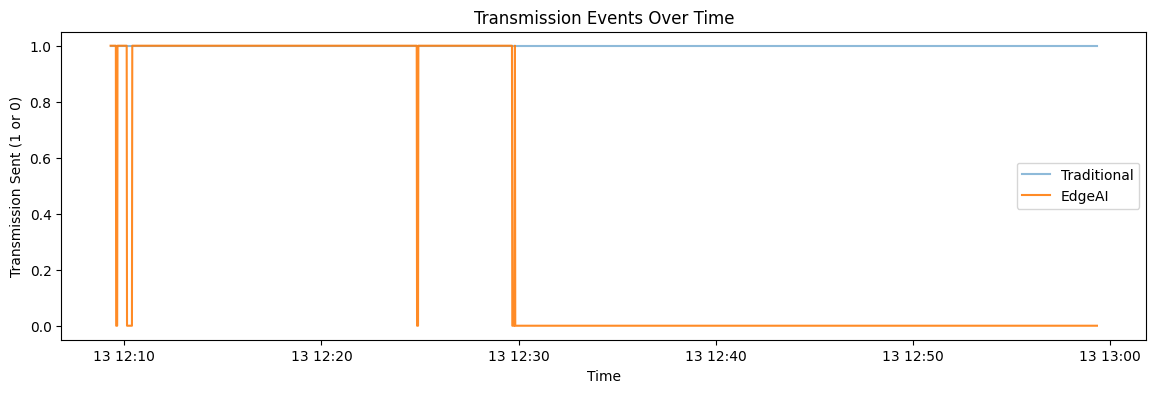

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(df_sim["timestamp"], df_sim["tx_traditional"], label="Traditional", alpha=0.5)
plt.plot(df_sim["timestamp"], df_sim["tx_edge"], label="EdgeAI", alpha=0.9)
plt.legend()
plt.title("Transmission Events Over Time")
plt.xlabel("Time")
plt.ylabel("Transmission Sent (1 or 0)")
plt.show()


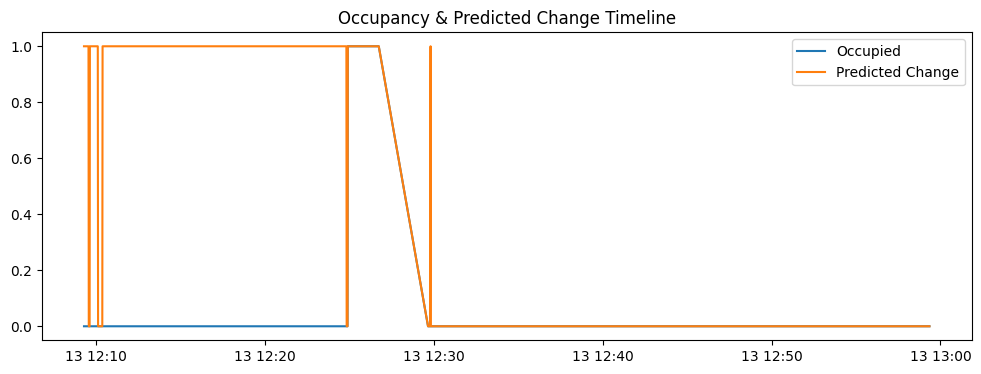

In [21]:
plt.figure(figsize=(12,4))
plt.plot(df_sim["timestamp"], df_sim["occupied_now"], label="Occupied")
plt.plot(df_sim["timestamp"], df_sim["pred_label"], label="Predicted Change")
plt.legend()
plt.title("Occupancy & Predicted Change Timeline")
plt.show()
